In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import joblib
from google.cloud import storage

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install 

In [2]:
!pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2


In [3]:
!ls /home/jupyter/.cache/kagglehub/datasets/ealaxi/paysim1/versions/2

PS_20174392719_1491204439457_log.csv


In [4]:
# Load dataset
#BUCKET_NAME=""
#if BUCKET_NAME == "bucket2025anita":
#   FILE_PATH = "[local-file-path]"
#else :
#   FILE_PATH = "gs://"+BUCKET_NAME + "/PS_20174392719_1491204439457_log.csv"

df = pd.read_csv("gs://bucket2025anita/PS_20174392719_1491204439457_log.csv")
df.shape

(6362620, 11)

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


Text(0, 0.5, 'Amount')

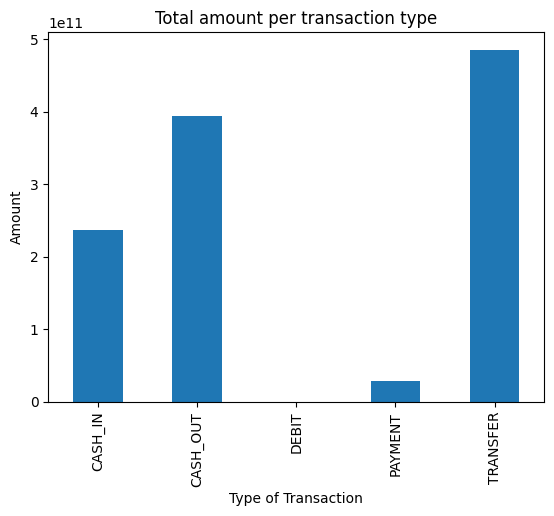

In [7]:
print(df.type.value_counts())
var = df.groupby('type').amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
var.plot(kind='bar')
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel('Type of Transaction')
ax1.set_ylabel('Amount')

In [8]:
#working with imbalanced data
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [ ]:
#piedata = df.groupby(['isFlaggedFraud']).sum()
#f, axes = plt.subplots(1,1, figsize=(6,6))

In [ ]:
#axes.set_title("% of fraud transaction detected")
#piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,shadow=False,autopct='%1.1f%%');
#axes.set_ylabel('');
#plt.legend(loc='upper left',labels=['Not Detected','Detected'])
#plt.show()

In [9]:
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)
X = pd.concat([df.drop('type', axis=1), pd.get_dummies(df['type'])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,False,False,False,True,False


In [10]:
y = X[['isFraud']]
X = X.drop(['isFraud'],axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42, shuffle=False)
print (X_train.shape, X_test.shape)

(4453834, 11) (1908786, 11)


In [13]:
%%time
forest=RandomForestClassifier()
forest.fit(X_train,y_train)

CPU times: user 13min 26s, sys: 5.69 s, total: 13min 32s
Wall time: 13min 32s


RandomForestClassifier()

In [14]:
y_prob=forest.predict_proba(X_test)
y_pred=forest.predict(X_test)

print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
print('F1 - score :',(f1_score(y_test,y_pred)))

print('Confusion_matrix : ')
print(confusion_matrix(y_test,y_pred))

print("classification_report")
print(classification_report(y_test,y_pred))

AUPRC : 0.9251220228740963
F1 - score : 0.8506696707973463
Confusion_matrix : 
[[1904195      21]
 [   1172    3398]]
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       0.99      0.74      0.85      4570

    accuracy                           1.00   1908786
   macro avg       1.00      0.87      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786



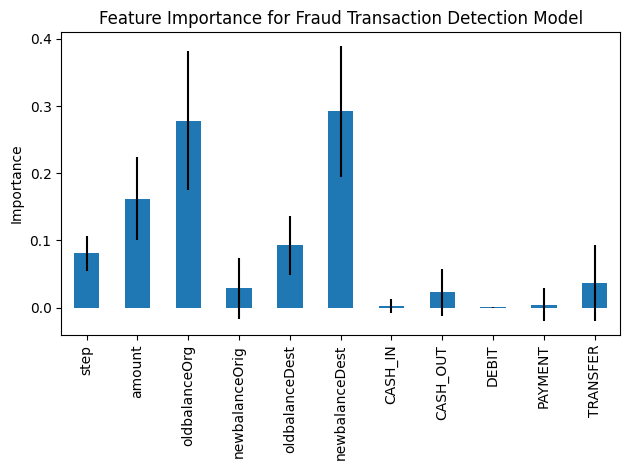

In [15]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()



In [16]:
BUCKET_NAME="bucket2025anita"

In [17]:
FILE_NAME = "model.joblib"
joblib.dump(forest, FILE_NAME)

# Upload the saved model file to GCS

BLOB_PATH = "fraud_detection/model/"
BLOB_NAME = BLOB_PATH + FILE_NAME

bucket = storage.Client().bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename("model.joblib")

In [18]:
REGION = "us-central1"
MODEL_DISPLAY_NAME = "fraud-detection-model"
ARTIFACT_GCS_PATH = f'gs://{BUCKET_NAME}/{BLOB_PATH}'


! gcloud beta ai models upload \
 --region=$REGION \
 --display-name=$MODEL_DISPLAY_NAME \
 --container-image-uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.0-24:latest" \
 --artifact-uri=$ARTIFACT_GCS_PATH



Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [2507908954063896576]...done.                            


To take a quick anonymous survey, run:
  $ gcloud survey



In [22]:
! gcloud beta ai models list \
 --region $REGION \
 --filter=display_name=$MODEL_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
9103055777962131456  fraud-detection-model


In [23]:
MODEL_ID = "9103055777962131456"

In [27]:
ENDPOINT_DISPLAY_NAME = "fraud-detection-model-ep1"

In [28]:
! gcloud beta ai endpoints create \
 --region=$REGION \
 --display-name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [8596212700315385856]...done.                            
Created Vertex AI endpoint: projects/344519065447/locations/us-central1/endpoints/6043224869024301056.


In [29]:
! gcloud beta ai endpoints list \
 --region=$REGION \
 --filter=display_name=$ENDPOINT_DISPLAY_NAME

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
ENDPOINT_ID          DISPLAY_NAME
6043224869024301056  fraud-detection-model-ep1


In [32]:
ENDPOINT_ID = "6043224869024301056"

In [33]:
DEPLOYED_MODEL_NAME = "fraud-detection-model-v1"
MACHINE_TYPE = "n1-standard-2"

In [ ]:
! gcloud beta ai endpoints deploy-model $ENDPOINT_ID\
 --region=$REGION \
 --model=$MODEL_ID \
 --display-name=$DEPLOYED_MODEL_NAME \
 --machine-type=$MACHINE_TYPE \
 --traffic-split=0=100

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [3274136617228435456]...⠏                                

In [ ]:
DEPLOYED_MODEL_ID = "fraud-detection-model-ep1"